In [39]:
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
import skimage as ski
import tqdm
import pandas as pd
import scipy.stats
import os

dir_path = os.path.abspath('')

imageSize = 250

primaryImage = np.load('subBeadPackPy250_justSpheres.npy')
secondaryImage = np.load('finalSimFile3D250.npy')
primaryImage[primaryImage == 255] = 1

primaryImage = np.transpose(primaryImage)
secondaryImage = np.transpose(secondaryImage)

velSecondaryMat = sio.loadmat(dir_path + '/velocityFiles/velocityNormCodeSecondary_250test.mat')
velDataNormSecondary = velSecondaryMat['velNorm']

velPrimaryMat = sio.loadmat(dir_path+'/velocityFiles/velocityNormCodePrimary_250test.mat')
velDataNormPrimary = velPrimaryMat['velNorm']

resolution = 16.81E-6 # adding resolution in meters

# Plot pore space and velocity

Plot the sample with secondary porosity

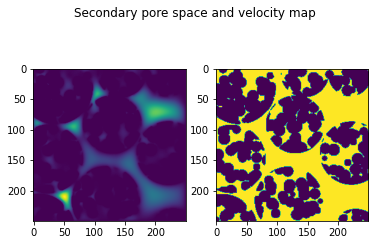

In [40]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormSecondary[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

fig.savefig('secondaryPoreImage.png')

In [41]:
secondaryImageOut = np.copy(secondaryImage)
secondaryImageOut = secondaryImageOut.astype('int')
secondaryImageOut[secondaryImage == 1] = 255

# Save vtk files
ps.io.to_vtk(velDataNormSecondary, 'secondaryVelocityImage')
ps.io.to_vtk(secondaryImageOut,'secondaryImage')

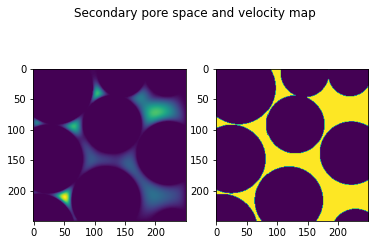

In [42]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])

fig.savefig('primaryPoreImage.png')

# Extract pore network information

In [43]:
snowFiltSecondary = ps.filters.snow_partitioning(im=secondaryImage,r_max=4,sigma=0.4, return_all=True)
poreInfoSecondary = ps.networks.regions_to_network(snowFiltSecondary.regions, dt=snowFiltSecondary.dt)

nRegions = np.unique(snowFiltSecondary.regions).size
secondaryPoreDiamVec = np.zeros(nRegions,)
secondaryPoreVolumeVec = np.zeros(nRegions,)

for a in range(0, poreInfoSecondary['pore.diameter'].size):
    secondaryPoreDiamVec[a] = poreInfoSecondary['pore.diameter'][a]
    secondaryPoreVolumeVec[a] = poreInfoSecondary['pore.volume'][a]

secondaryRegions = snowFiltSecondary.regions


------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1484
Peaks after trimming saddle points:  957
Peaks after trimming nearby peaks:  937
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 937/937 [00:07<00:00, 117.68it/s]


In [44]:
snowFiltPrimary = ps.filters.snow_partitioning(im=primaryImage,r_max=4,sigma=0.4, return_all=True)
poreInfoPrimary = ps.networks.regions_to_network(snowFiltPrimary.regions, dt=snowFiltPrimary.dt)

nRegions = np.unique(snowFiltPrimary.regions).size
primaryPoreDiamVec = np.zeros(nRegions,)
primaryPoreVolumeVec = np.zeros(nRegions,)

for a in range(0, poreInfoPrimary['pore.diameter'].size):
    primaryPoreDiamVec[a] = poreInfoPrimary['pore.diameter'][a]
    primaryPoreVolumeVec[a] = poreInfoPrimary['pore.volume'][a]

primaryRegions = snowFiltPrimary.regions

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  113
Peaks after trimming saddle points:  104
Peaks after trimming nearby peaks:  93
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 93/93 [00:03<00:00, 23.33it/s]


In [45]:
#ps.io.to_vtk(secondaryRegions,'snowRegionsSecondary')
#ps.io.to_vtk(primaryRegions,'snowRegionsPrimary')

In [46]:
snowIM = snowFiltSecondary.im
print('The initial image has', np.sum(secondaryImage),'number of pore elements')

snowRegionIM = secondaryRegions[secondaryRegions > 0]
print('The identified pore regions account for',len(snowRegionIM),'number of elements')

diff = np.abs(len(snowRegionIM) - np.sum(secondaryImage))
print('The difference between these two is', diff)
print('This difference must be due to some SNOW algorithm imperfections')

The initial image has 8437192 number of pore elements
The identified pore regions account for 8435161 number of elements
The difference between these two is 2031
This difference must be due to some SNOW algorithm imperfections


# Plot distribution of pore diameter

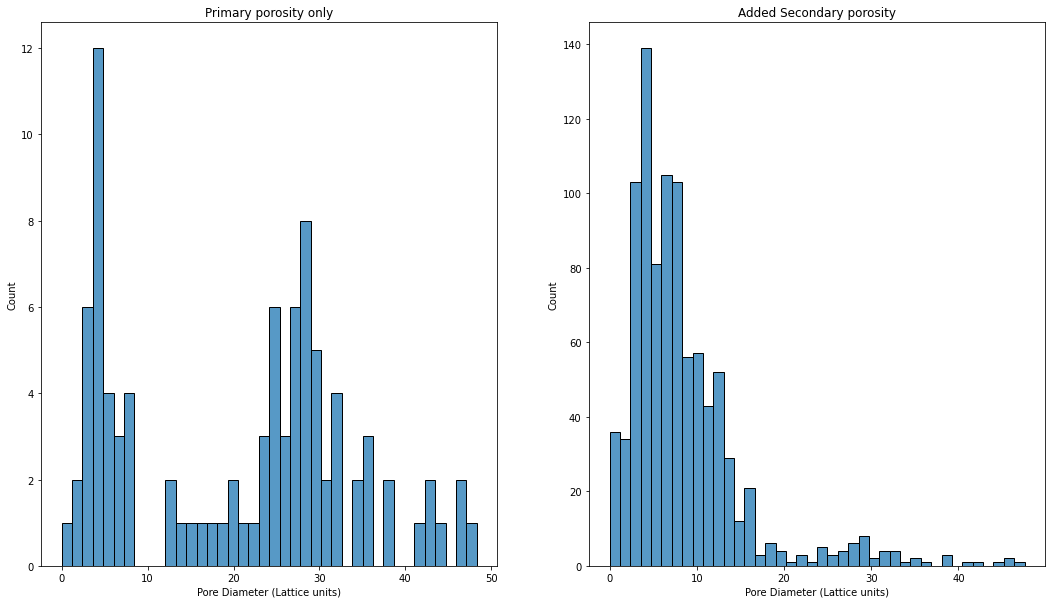

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.histplot(data=primaryPoreDiamVec, ax=axes[0],
             bins=int(40))
axes[0].set_title('Primary porosity only')
axes[0].set_xlabel('Pore Diameter (Lattice units)')

sns.histplot(data=secondaryPoreDiamVec, ax=axes[1],
             bins=int(40))
axes[1].set_title('Added Secondary porosity')
axes[1].set_xlabel('Pore Diameter (Lattice units)')

fig.savefig('poreDiamHist.png')

### I will say pore diameter > 20 units are "big pores"

## Try looking at pore volume instead

/home/akendrick/anaconda3/envs/LABMOPS/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


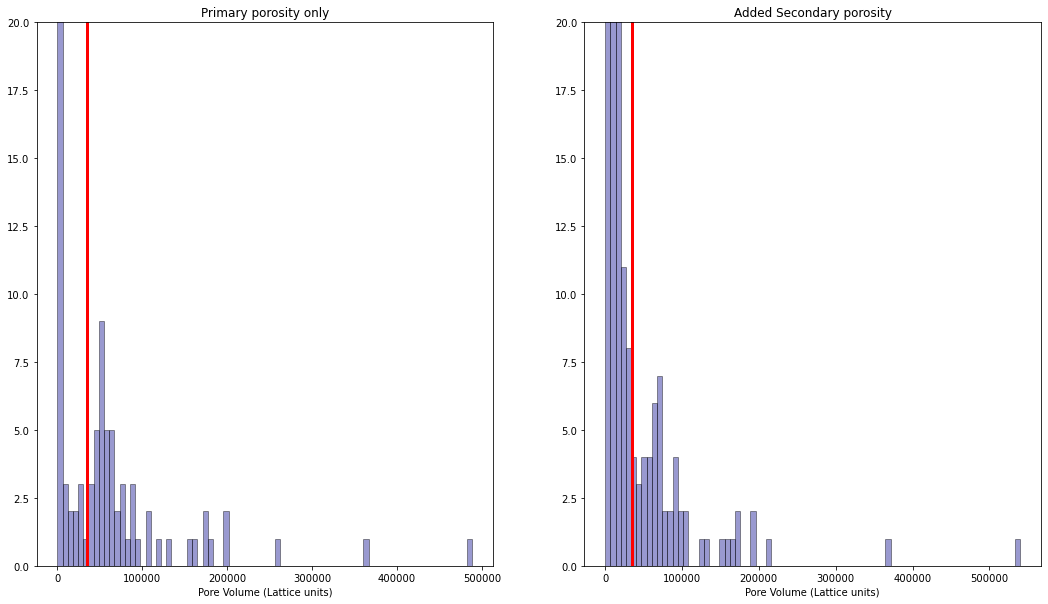

In [38]:
poreVolumeThresh = 35000
yMax = 20

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.distplot(primaryPoreVolumeVec, ax=axes[0], hist=True, kde=False,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[0].set_title('Primary porosity only')
axes[0].set_xlabel('Pore Volume (Lattice units)')
axes[0].set_ylim([0,yMax])
axes[0].plot([poreVolumeThresh, poreVolumeThresh],[0,yMax],'r',lw=3)

sns.distplot(secondaryPoreVolumeVec, ax=axes[1], hist=True, kde=False,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[1].set_title('Added Secondary porosity')
axes[1].set_xlabel('Pore Volume (Lattice units)')
axes[1].set_ylim([0,20])
axes[1].plot([poreVolumeThresh, poreVolumeThresh],[0,yMax],'r',lw=3)

fig.savefig('poreVolumeHist.png',facecolor='w', edgecolor='w')

### I will say pore volume > 35000 are "big pores"

# Skeleton implementation

Find skeleton for secondary image and collect info

In [39]:
# Skeleton for secondary image
cubeSize = len(secondaryImage)
visit = np.zeros(len(np.unique(secondaryRegions)))
secondaryPoreDiamImage = np.zeros(secondaryImage.shape)
allSecondaryRegions = np.unique(secondaryRegions)
tempImage = np.zeros(secondaryRegions.shape)
secondaryPoreDiamVectorSkeleton = np.zeros(len(allSecondaryRegions))

secondarySkelImage = ski.morphology.skeletonize(secondaryImage)

for a in tqdm.tqdm(range(0,len(allSecondaryRegions)), 'Main loop'):
            regionLabel = a
            if regionLabel != 0: # Don't want grains to be counted
                if visit[regionLabel] == 0:
                    visit[regionLabel] = 1
                    # Adjust indices for pore information, regionlabel = 0 is pore 1 in poreInfo
                    poreDiam = secondaryPoreDiamVec[regionLabel - 1]
                    secondaryPoreDiamImage[secondaryRegions == regionLabel] = poreDiam
                    



Main loop: 100%|██████████| 938/938 [00:09<00:00, 97.17it/s]


In [40]:
# Skeleton for primary image
cubeSize = len(primaryImage)
visit = np.zeros(len(np.unique(primaryRegions)))
primaryPoreDiamImage = np.zeros(primaryImage.shape)
allPrimaryRegions = np.unique(primaryRegions)
tempImage = np.zeros(primaryRegions.shape)
primaryPoreDiamVectorSkeleton = np.zeros(len(allPrimaryRegions))

primarySkelImage = ski.morphology.skeletonize(primaryImage)

for a in tqdm.tqdm(range(0,len(allPrimaryRegions)), 'Main loop'):
            regionLabel = a
            if regionLabel != 0: # Don't want grains to be counted
                if visit[regionLabel] == 0:
                    visit[regionLabel] = 1
                    # Adjust indices for pore information, regionlabel = 0 is pore 1 in poreInfo
                    poreDiam = primaryPoreDiamVec[regionLabel - 1]
                    primaryPoreDiamImage[primaryRegions == regionLabel] = poreDiam



Main loop: 100%|██████████| 94/94 [00:00<00:00, 94.77it/s] 


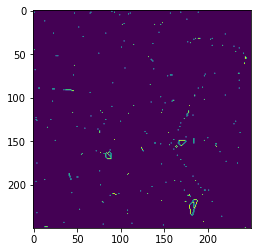

In [23]:
#secondarySkelImage[secondaryImage == 0] = 0
ps.io.to_vtk(secondarySkelImage,'secondarySkeletonWholeImage')
plt.imshow(secondarySkelImage[:,:,40])
plt.savefig('secondarySkeletonSlice.png')

secondaryImageOut = np.copy(secondaryImage)
secondaryImageOut = secondaryImageOut.astype(int)
secondaryImageOut[secondaryImage == 1] = 255
ps.io.to_vtk(secondaryImageOut,'secondaryImage')

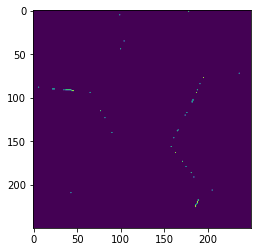

In [24]:
#################################################################
ps.io.to_vtk(primarySkelImage,'primarySkeletonWholeImage')
plt.imshow(primarySkelImage[:,:,40])
plt.savefig('primarySkeletonSlice.png')

primaryImageOut = np.copy(primaryImage)
primaryImageOut = primaryImageOut.astype(int)
primaryImageOut[primaryImage == 1] = 255
ps.io.to_vtk(primaryImageOut,'primaryImage')

# Now plot velocitites on skeleton and extract information

In [41]:
secondaryVelocitiesSkeleton = []
secondaryPoreDiamSkeleton = []
secondaryPoreRegionSkeleton = []

for a in tqdm.tqdm(range(0,cubeSize), 'Secondary porosity loop'):
    for b in range(0,cubeSize):
        for c in range(0, cubeSize):
            # If the primary skeleton image is not zero, then save the velocity data
            # The primary skeleton image will be zero for all indices except the skeleton found above which
            # should be the values in the middle of all of the pores, no pore walls etc...
            # This array should contain the velocity data we want to use to define flow/no flow etc...
            if secondarySkelImage[a,b,c] != 0:
                secondaryVelocitiesSkeleton = np.append(secondaryVelocitiesSkeleton,velDataNormSecondary[a,b,c])
                secondaryPoreDiamSkeleton = np.append(secondaryPoreDiamSkeleton, secondaryPoreDiamImage[a,b,c])
                secondaryPoreRegionSkeleton = np.append(secondaryPoreRegionSkeleton, secondaryRegions[a,b,c])

Secondary porosity loop: 100%|██████████| 250/250 [00:38<00:00,  6.49it/s]


In [42]:
primaryVelocitiesSkeleton = []
primaryPoreDiamSkeleton = []
primaryPoreRegionSkeleton = []

for a in tqdm.tqdm(range(0,cubeSize), 'Primary porosity loop'):
    for b in range(0,cubeSize):
        for c in range(0, cubeSize):
            # If the primary skeleton image is not zero, then save the velocity data
            # The primary skeleton image will be zero for all indices except the skeleton found above which
            # should be the values in the middle of all of the pores, no pore walls etc...
            # This array should contain the velocity data we want to use to define flow/no flow etc...
            if primarySkelImage[a,b,c] != 0:
                primaryVelocitiesSkeleton = np.append(primaryVelocitiesSkeleton,velDataNormPrimary[a,b,c])
                primaryPoreDiamSkeleton = np.append(primaryPoreDiamSkeleton, primaryPoreDiamImage[a,b,c])
                primaryPoreRegionSkeleton = np.append(primaryPoreRegionSkeleton, primaryRegions[a,b,c])

Primary porosity loop: 100%|██████████| 250/250 [00:31<00:00,  7.94it/s]


In [ ]:
primaryFiltSkelImage = np.where(primarySkelImage,True,False)
np.shape(primaryFiltSkelImage)

primaryVelocitiesSkeleton = velDataNormPrimary[primaryFiltSkelImage]
np.shape(primaryVelocitiesSkeleton)

# Plot pore velocities with pore diameters

Try taking computing a representative velocity threshold

In [43]:
secondary_metric_PoreVelocity =  []
secondaryMeanPoreVelocity =  []
secondarySkeletonPoreDiam = []
secondarySkeletonPoreRegion = []
secondarySkeletonPoreVolume = []

for a in tqdm.tqdm(range(0, len(allSecondaryRegions)), 'Main Loop'):
    currentRegion = a
    if currentRegion != 0:
        regionImage = np.where(secondaryPoreRegionSkeleton == currentRegion)
        skeletonPoreVel = secondaryVelocitiesSkeleton[regionImage]


        
        
        
        #skeletonPoreVel = secondaryVelocitiesSkeleton[secondaryPoreRegionSkeleton == currentRegion]
        secondaryMeanPoreVelocity = np.append(secondaryMeanPoreVelocity, np.mean(skeletonPoreVel))
        secondary_metric_PoreVelocity = np.append(secondary_metric_PoreVelocity, np.median(skeletonPoreVel))

        # Adjust indices between regionProps and snow algorithm
        secondarySkeletonPoreDiam = np.append(secondarySkeletonPoreDiam, poreInfoSecondary['pore.diameter'][currentRegion-1] )
        secondarySkeletonPoreVolume = np.append(secondarySkeletonPoreVolume, poreInfoSecondary['pore.volume'][currentRegion-1])

        secondarySkeletonPoreRegion = np.append(secondarySkeletonPoreRegion, currentRegion)

Main Loop:   0%|          | 0/938 [00:00<?, ?it/s]/home/akendrick/anaconda3/envs/LABMOPS/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
Main Loop: 100%|██████████| 938/938 [00:00<00:00, 8283.20it/s]


In [44]:
primary_metric_PoreVelocity =  []
primaryMeanPoreVelocity =  []
primarySkeletonPoreDiam = []
primarySkeletonPoreRegion = []
primarySkeletonPoreVolume = []

for a in tqdm.tqdm(range(0, len(allPrimaryRegions)), 'Main Loop'):
    currentRegion = a
    if currentRegion != 0:
        skeletonPoreVel = primaryVelocitiesSkeleton[primaryPoreRegionSkeleton == currentRegion]
        primaryMeanPoreVelocity = np.append(primaryMeanPoreVelocity, np.mean(skeletonPoreVel))
        primary_metric_PoreVelocity = np.append(primary_metric_PoreVelocity, np.median(skeletonPoreVel))

        # Adjust indices between regionProps and snow algorithm
        primarySkeletonPoreDiam = np.append(primarySkeletonPoreDiam, poreInfoPrimary['pore.diameter'][currentRegion-1] )
        primarySkeletonPoreVolume = np.append(primarySkeletonPoreVolume, poreInfoPrimary['pore.volume'][currentRegion-1])

        primarySkeletonPoreRegion = np.append(primarySkeletonPoreRegion, currentRegion)

Main Loop: 100%|██████████| 94/94 [00:00<00:00, 7947.28it/s]


# Define low flow and large pore thresholds

In [45]:
lowFlowVelCutoff = 1.42 * 10 ** float(-5) # 0.5 * 10 ** float(-5)
poreDiamThresh = 20
poreVolumeThresh = 35000

### Secondary porosity sample

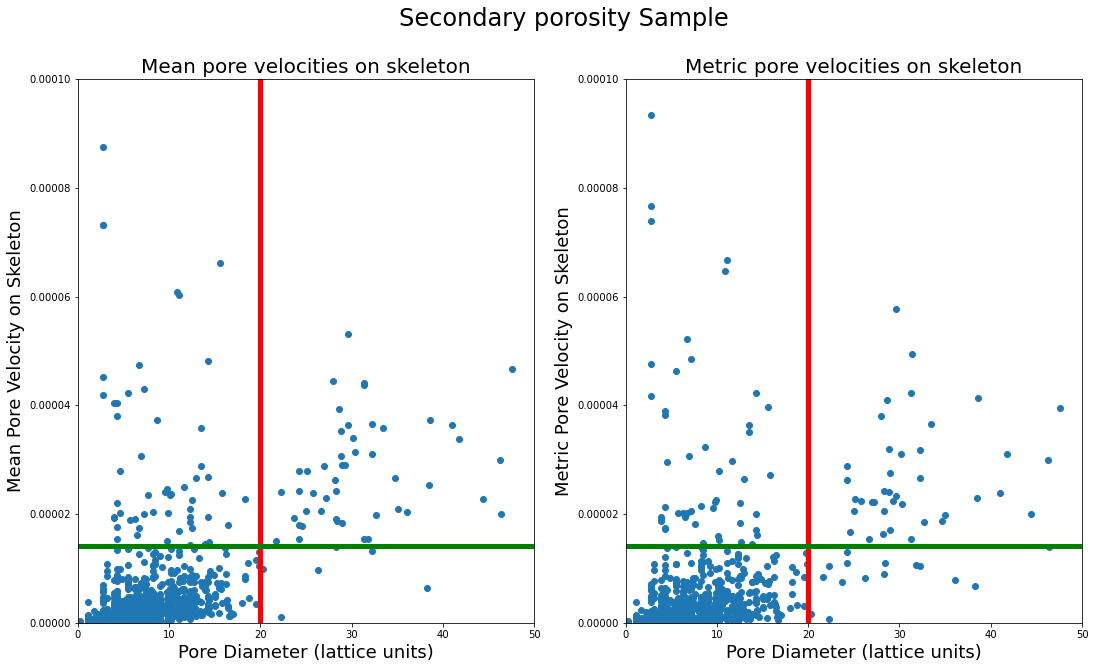

In [46]:
yMax = 0.0001


fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Secondary porosity Sample', fontsize=24)

axes[0].scatter(secondarySkeletonPoreDiam, secondaryMeanPoreVelocity)
axes[0].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[0].set_ylabel('Mean Pore Velocity on Skeleton', fontsize=18)
axes[0].set_title('Mean pore velocities on skeleton', fontsize=20)
axes[0].set_ylim([0,yMax])
axes[0].set_xlim([0,50])
axes[0].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[0].plot([0,50],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)


axes[1].scatter(secondarySkeletonPoreDiam, secondary_metric_PoreVelocity)
axes[1].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[1].set_ylabel('Metric Pore Velocity on Skeleton', fontsize=18)
axes[1].set_title('Metric pore velocities on skeleton', fontsize=20)
axes[1].set_ylim([0,yMax])
axes[1].set_xlim([0,50])
axes[1].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[1].plot([0,50],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

fig.savefig('secondaryPoreVelAveraging.png')


### Primary porosity sample

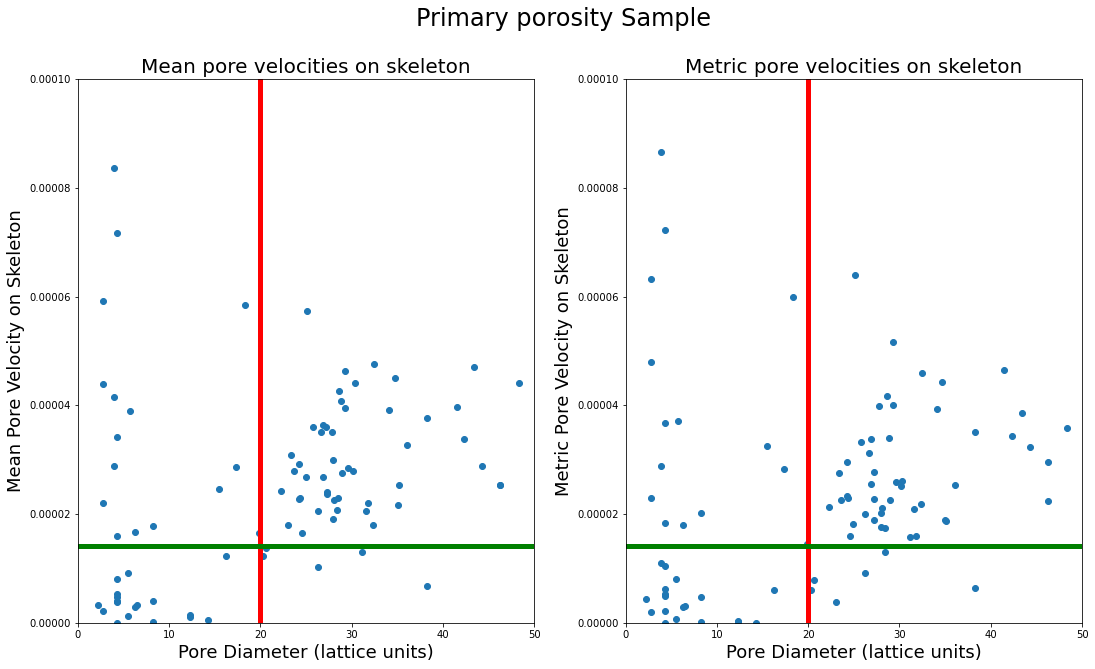

In [47]:

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Primary porosity Sample', fontsize=24)

axes[0].scatter(primarySkeletonPoreDiam, primaryMeanPoreVelocity)
axes[0].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[0].set_ylabel('Mean Pore Velocity on Skeleton', fontsize=18)
axes[0].set_title('Mean pore velocities on skeleton', fontsize=20)
axes[0].set_ylim([0,yMax])
axes[0].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[0].set_xlim([0,50])
axes[0].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[0].plot([0,50],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

axes[1].scatter(primarySkeletonPoreDiam, primary_metric_PoreVelocity)
axes[1].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[1].set_ylabel('Metric Pore Velocity on Skeleton', fontsize=18)
axes[1].set_title('Metric pore velocities on skeleton', fontsize=20)
axes[1].set_ylim([0,yMax])
axes[1].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[1].set_xlim([0,50])
axes[1].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[1].plot([0,50],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

fig.savefig('primaryPoreVelAveraging.png')



### Plot pore velocity metric for both samples

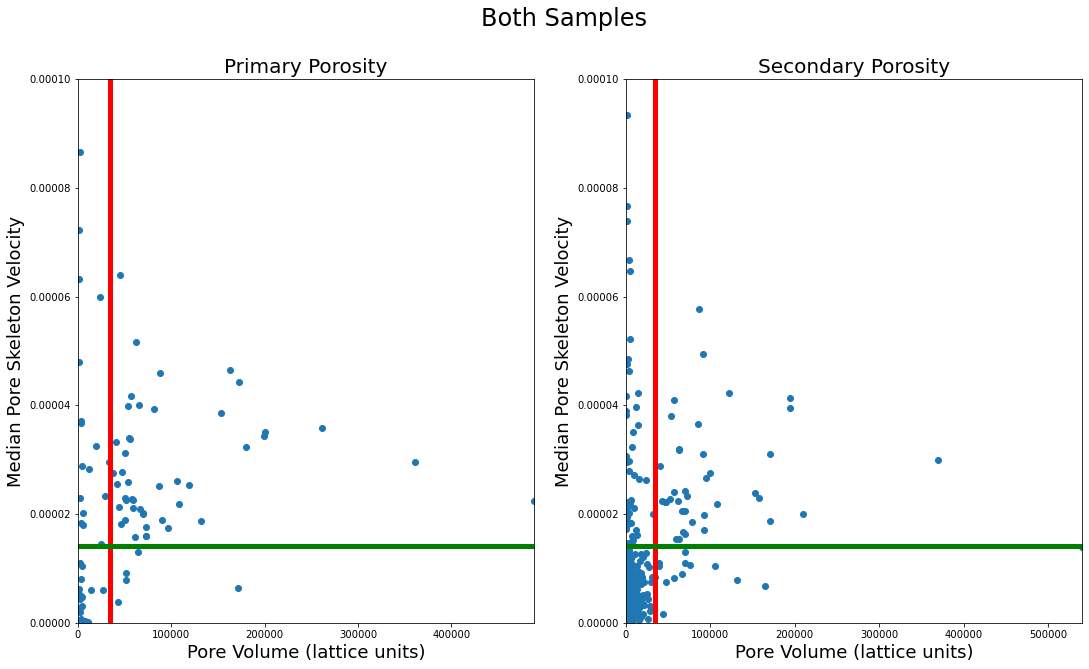

In [48]:
yMax = 0.0001

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Both Samples', fontsize=24)

axes[0].scatter(primarySkeletonPoreVolume, primary_metric_PoreVelocity)
axes[0].set_xlabel('Pore Volume (lattice units)', fontsize=18)
axes[0].set_ylabel('Median Pore Skeleton Velocity', fontsize=18)
axes[0].set_title('Primary Porosity', fontsize=20)
axes[0].set_ylim([0,yMax])
axes[0].set_xlim([0,np.max(primarySkeletonPoreVolume)])
axes[0].plot([poreVolumeThresh, poreVolumeThresh],[0,yMax],'r',lw=5)
axes[0].plot([0,np.max(primarySkeletonPoreVolume)],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

axes[1].scatter(secondarySkeletonPoreVolume, secondary_metric_PoreVelocity)
axes[1].set_xlabel('Pore Volume (lattice units)', fontsize=18)
axes[1].set_ylabel('Median Pore Skeleton Velocity', fontsize=18)
axes[1].set_title('Secondary Porosity', fontsize=20)
axes[1].set_ylim([0,yMax])
axes[1].set_xlim([0,np.max(secondarySkeletonPoreVolume)])
axes[1].plot([poreVolumeThresh, poreVolumeThresh],[0,yMax],'r',lw=5)
axes[1].plot([0,np.max(secondarySkeletonPoreVolume)],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

fig.savefig('bothPorosityMetric.png', dpi=300, facecolor='w', edgecolor='w')


## Try histogram of velocity metric with custom bins and pore diam filt

Small pores
886
just large pores
51


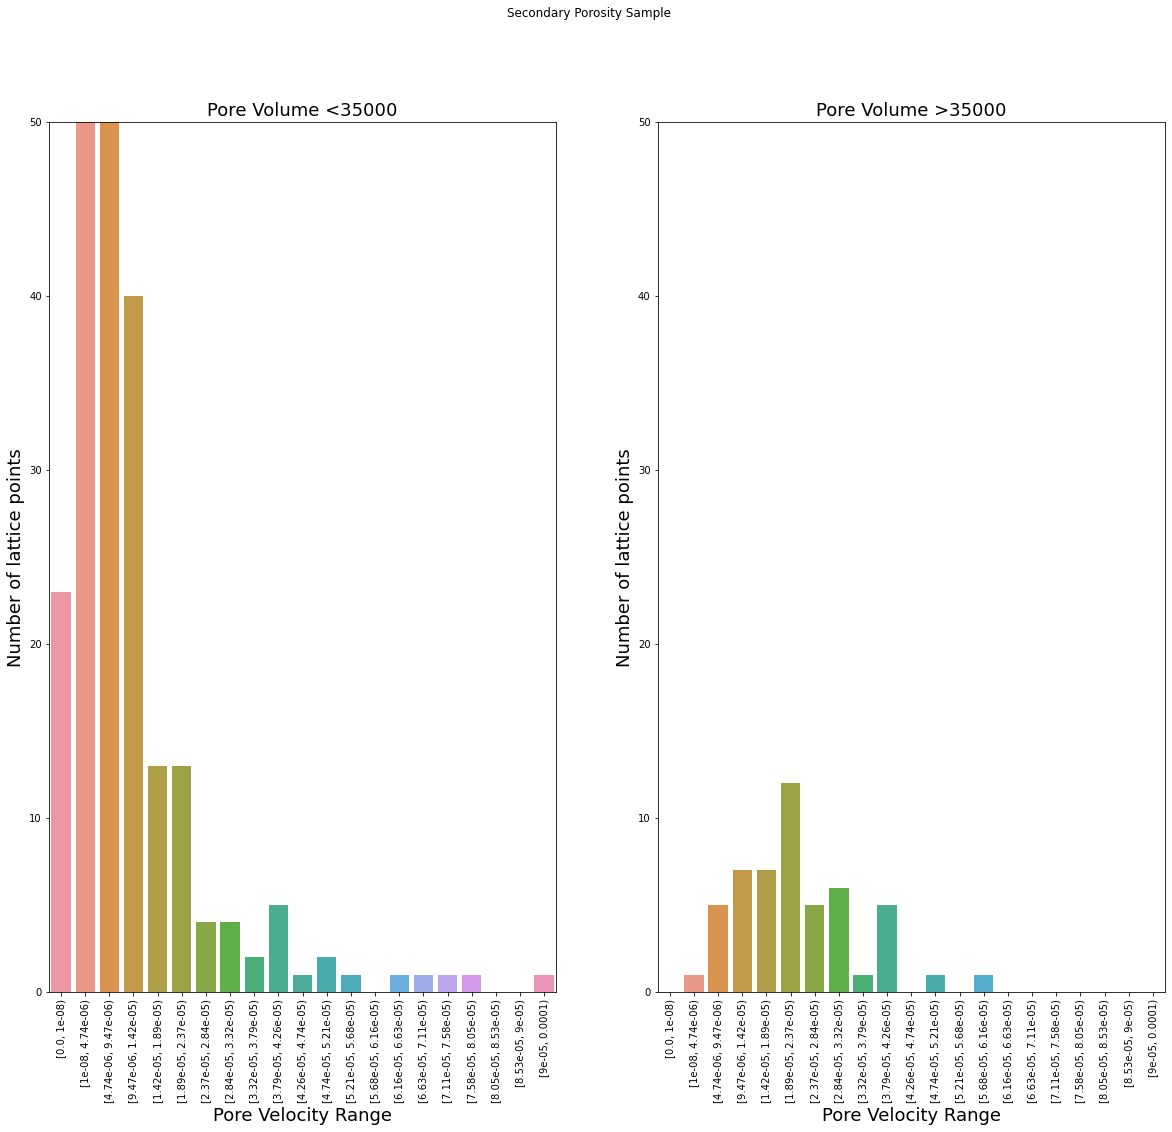

In [49]:
metricFilt = secondary_metric_PoreVelocity[secondarySkeletonPoreVolume < poreVolumeThresh]
# number of large pores
smallPores = secondarySkeletonPoreVolume[secondarySkeletonPoreVolume < poreVolumeThresh]
largePores = secondarySkeletonPoreVolume[secondarySkeletonPoreVolume > poreVolumeThresh]

print('Small pores')
print(len(smallPores))

bins = np.linspace(0, 0.00009, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 0.0001)
bins = np.insert(bins, 1, 0.00000001)

df_small = pd.DataFrame({'skelVel': metricFilt,
                        'vel_group': pd.cut(metricFilt, bins=bins, right=False)})


############################################################
metricFilt = secondary_metric_PoreVelocity[secondarySkeletonPoreVolume > poreVolumeThresh]
# number of large pores
numLargePores = secondarySkeletonPoreVolume[secondarySkeletonPoreVolume > poreVolumeThresh]

print('just large pores')
print(len(numLargePores))

df_large = pd.DataFrame({'skelVel': metricFilt,
                        'vel_group': pd.cut(metricFilt, bins=bins, right=False)})

############################################################

fig, axes = plt.subplots(1, 2, figsize=(20, 16))
fig.suptitle('Secondary Porosity Sample')

sns.countplot(data=df_small,x='vel_group',ax=axes[0] )
sns.countplot(data=df_large,x='vel_group',ax=axes[1])

axes[0].set_title('Pore Volume <'+str(poreVolumeThresh), fontsize=18)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_ylim([0,50])
axes[0].set_xlabel('Pore Velocity Range', fontsize=18)
axes[0].set_ylabel('Number of lattice points', fontsize=18)

axes[1].set_title('Pore Volume >'+str(poreVolumeThresh), fontsize=18)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_ylim([0,50])
axes[1].set_xlabel('Pore Velocity Range', fontsize=18)
axes[1].set_ylabel('Number of lattice points', fontsize=18)

fig.savefig('secondaryCustomHist.png', dpi=300, facecolor='w', edgecolor='w')

In [24]:
metricFilt = primary_metric_PoreVelocity[primarySkeletonPoreVolume < poreVolumeThresh]
# number of large pores
numSmallPores = primarySkeletonPoreVolume[primarySkeletonPoreVolume < poreVolumeThresh]
print('Small pores')
print(len(numSmallPores))

bins = np.linspace(0, 0.00009, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 0.0001)
bins = np.insert(bins, 1, 0.00000001)

df_small = pd.DataFrame({'skelVel': metricFilt,
                        'vel_group': pd.cut(metricFilt, bins=bins, right=False)})


############################################################
IQRFilt = primary_metric_PoreVelocity[primarySkeletonPoreVolume > poreVolumeThresh]
# number of large pores
numLargePores = primarySkeletonPoreVolume[primarySkeletonPoreVolume > poreVolumeThresh]
print('just large pores')
print(len(numLargePores))

df_large = pd.DataFrame({'skelVel': metricFilt,
                        'vel_group': pd.cut(metricFilt, bins=bins, right=False)})

############################################################

fig, axes = plt.subplots(1, 2, figsize=(20, 16))
fig.suptitle('Primary Porosity Sample')

sns.countplot(data=df_small,x='vel_group',ax=axes[0] )
sns.countplot(data=df_large,x='vel_group',ax=axes[1])

axes[0].set_title('Pore Volume <'+str(poreVolumeThresh), fontsize=18)
axes[1].set_title('Pore Volume >'+str(poreVolumeThresh), fontsize=18)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[0].set_ylim([0,50])
axes[1].set_ylim([0,50])

axes[0].set_xlabel('Pore Velocity Range', fontsize=18)
axes[0].set_ylabel('Number of lattice points', fontsize=18)

axes[1].set_xlabel('Pore Velocity Range', fontsize=18)
axes[1].set_ylabel('Number of lattice points', fontsize=18)

fig.savefig('primaryCustomHist.png', dpi=300, facecolor='w', edgecolor='w')

TypeError: '<' not supported between instances of 'list' and 'int'

### Plot velocity histogram for all pores, both samples

In [61]:
bins = np.linspace(0, 0.00009, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 0.0001)
bins = np.insert(bins, 1, 0.00000001)

df_primary = pd.DataFrame({'skelVelPrimary': primary_metric_PoreVelocity,
                        'vel_groupPrimary': pd.cut(primary_metric_PoreVelocity, bins=bins, right=False)})

df_secondary = pd.DataFrame({'skelVelSecondary': secondary_metric_PoreVelocity,
                        'vel_groupSecondary': pd.cut(secondary_metric_PoreVelocity, bins=bins, right=False)})

In [71]:
primaryClrs = ['grey' if (x <=  lowFlowVelCutoff) else 'mediumturquoise' for x in bins ]
secondaryClrs = ['grey' if (x <=  lowFlowVelCutoff) else 'mediumturquoise' for x in bins]

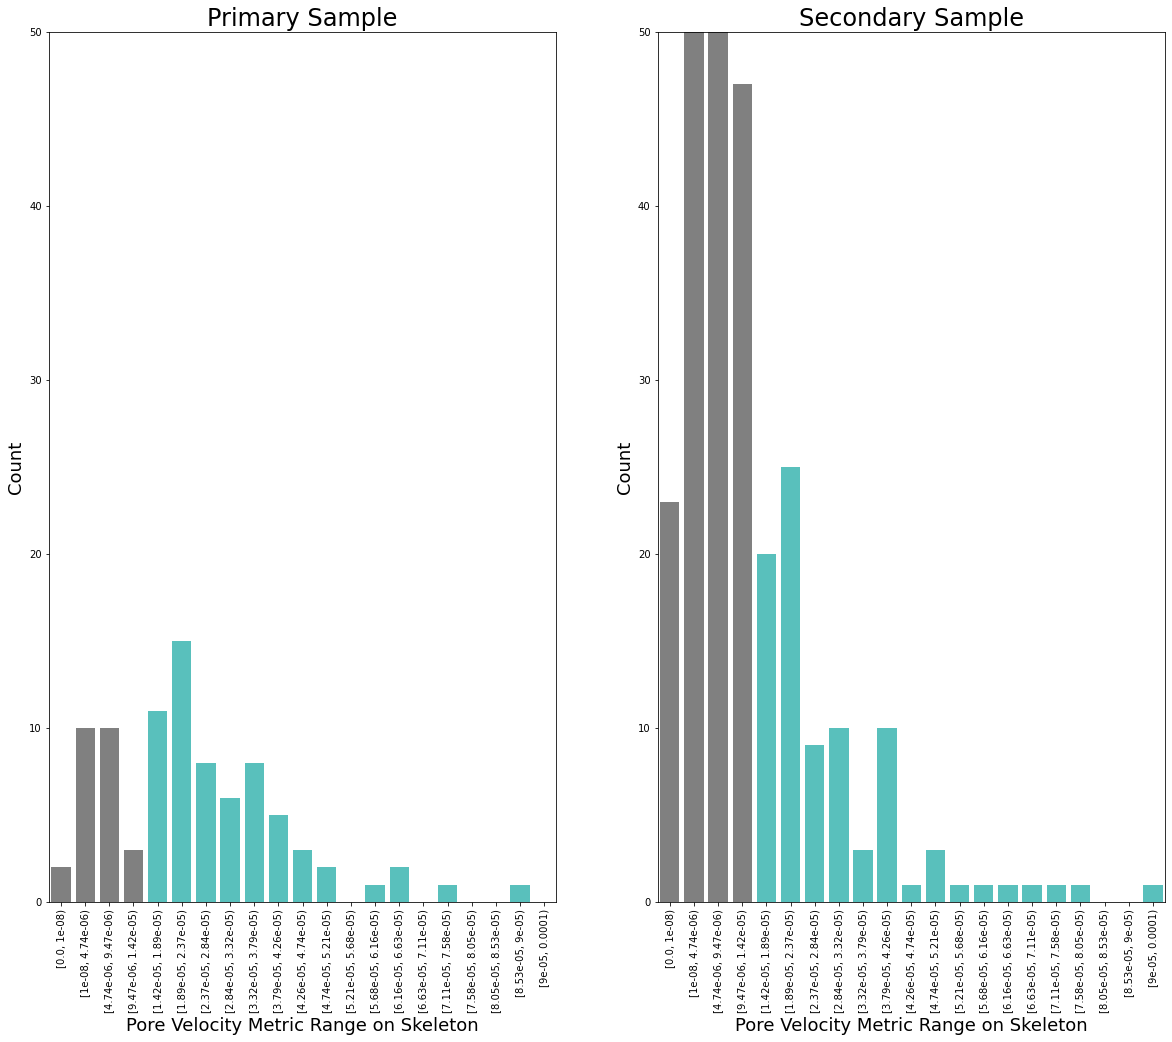

In [72]:
############################################################

fig, axes = plt.subplots(1, 2, figsize=(20, 16))


sns.countplot(data=df_primary,x='vel_groupPrimary',ax=axes[0],palette=primaryClrs )
sns.countplot(data=df_secondary,x='vel_groupSecondary',ax=axes[1],palette=secondaryClrs)

axes[0].set_title('Primary Sample', fontsize=24)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_ylim([0,50])
axes[0].set_xlabel('Pore Velocity Metric Range on Skeleton', fontsize=18)
axes[0].set_ylabel('Count', fontsize=18)

axes[1].set_title('Secondary Sample', fontsize=24)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_ylim([0,50])
axes[1].set_xlabel('Pore Velocity Metric Range on Skeleton', fontsize=18)
axes[1].set_ylabel('Count', fontsize=18)

fig.savefig('bothSamplesMetric_Hist.png', dpi=300, facecolor='w', edgecolor='w')




Separate all pores with low velocity

In [ ]:
bigSecondaryPores = secondarySkeletonPoreVolume[secondarySkeletonPoreVolume > poreVolumeThresh]
bigSecondaryPoreRegions = secondarySkeletonPoreRegion[secondarySkeletonPoreVolume > poreVolumeThresh]
bigSecondaryPoreVel = secondary_metric_PoreVelocity[secondarySkeletonPoreVolume > poreVolumeThresh]
#lowFlowPores = bigSecondaryPores[]

smallSecondaryPores = secondarySkeletonPoreVolume[secondarySkeletonPoreVolume <= poreVolumeThresh]
smallSecondaryPoreRegions = secondarySkeletonPoreRegion[secondarySkeletonPoreVolume <= poreVolumeThresh]
smallSecondaryPoreVel = secondary_metric_PoreVelocity[secondarySkeletonPoreVolume <= poreVolumeThresh]


lowFlowBigPoreRegions = bigSecondaryPoreRegions[bigSecondaryPoreVel <= lowFlowVelCutoff]
lowFlowBigPoreDiam = bigSecondaryPores[bigSecondaryPoreVel <= lowFlowVelCutoff]
lowFlowBigPoreFlow = bigSecondaryPoreVel[bigSecondaryPoreVel <= lowFlowVelCutoff]

highFlowBigPoreDiam = bigSecondaryPores[bigSecondaryPoreVel > lowFlowVelCutoff]

print('There are',str(len(lowFlowBigPoreDiam)),'low flow pores of large pore diameter')
print('There are',str(len(highFlowBigPoreDiam)),'high flow pores of large pore diameter')

In [ ]:
lowFlowBigIMOut = np.zeros(secondaryImage.shape)
lowFlowBigIM = np.zeros(secondaryImage.shape)
lowFlowBigCount = 0

highFlowBigIMOut = np.zeros(secondaryImage.shape)
highFlowBigIM = np.zeros(secondaryImage.shape)
highFlowBigCount = 0

for a in tqdm.tqdm(range(0,len(secondarySkeletonPoreRegion)),'Flow Region Loop'):

    currentRegion = secondarySkeletonPoreRegion[a]

    if currentRegion in lowFlowBigPoreRegions:
        lowFlowBigIMOut[secondaryRegions == currentRegion] = 255
        lowFlowBigIM[secondaryRegions == currentRegion] = 1
        lowFlowBigCount = lowFlowBigCount + 1
    else:
        if secondarySkeletonPoreVolume[a] > poreVolumeThresh:
            highFlowBigIMOut[secondaryRegions == currentRegion] = 255
            highFlowBigIM[secondaryRegions == currentRegion] = 1
            highFlowBigCount = highFlowBigCount + 1
            print('High Flow Big Pore', str(currentRegion))


print('Number of big pores with low flow is',str(lowFlowBigCount))
print('Number of big pores with high flow is',str(highFlowBigCount))

In [48]:
# Plot big flow regions to compare in paraview
# Write to vtk
ps.io.to_vtk(lowFlowBigIMOut,'lowFlowBigRegions')
ps.io.to_vtk(highFlowBigIMOut,'highFlowBigRegions')

In [ ]:
bigPoreIMOut = np.zeros(secondaryImage.shape)
bigPoreIM = np.zeros(secondaryImage.shape)
bigPoreCount = 0

smallPoreIMOut = np.zeros(secondaryImage.shape)
smallPoreIM = np.zeros(secondaryImage.shape)

for a in tqdm.tqdm(range(0,len(secondarySkeletonPoreRegion)),'Pore Region Loop'):

    currentRegion = secondarySkeletonPoreRegion[a]
    currentPoreVolume = secondarySkeletonPoreVolume[a]

    if currentPoreVolume > poreVolumeThresh:
        bigPoreIMOut[secondaryRegions == currentRegion] = 255
        bigPoreIM[secondaryRegions == currentRegion] = 1
        bigPoreCount = bigPoreCount + 1
    else:
        smallPoreIMOut[secondaryRegions == currentRegion] = 125
        smallPoreIM[secondaryRegions == currentRegion] = 1

print('Number of big pores is',str(bigPoreCount))

# Compute estimate of porosity domains

Total porosity

In [51]:
porosityCalc = ps.metrics.porosity(secondaryImage)
print('Total porosity:')
print(np.round(porosityCalc,2))

Total porosity:
0.54


Estimate of less-mobile porosity

In [53]:
# Get grains
flippedImage = np.copy(secondaryImage)
flippedImage[secondaryImage == 1] = 0
flippedImage[secondaryImage == 0] = 1

sumPorosity = np.sum(secondaryImage)/(np.sum(flippedImage)+np.sum(secondaryImage))
print('Summed porosity to check value')
print(np.round(sumPorosity,2))

lessMobileOnes = np.sum(lowFlowBigIM)
total = np.sum(flippedImage) + np.sum(secondaryImage)

lessMobilePorosity = lessMobileOnes/total
print('Less mobile porosity estimate:')
print(np.round(lessMobilePorosity,2))

print('Less mobile fraction of porosity')
lessMobileFrac = (lessMobilePorosity/porosityCalc)
print(np.round(lessMobileFrac,2))

Summed porosity to check value
0.54
Less mobile porosity estimate:
0.09
Less mobile fraction of porosity
0.17


## Estimate how much of "big pores" flow

In [57]:
bigPoreSum = np.sum(bigPoreIM)
smallPoreSum = np.sum(smallPoreIM)

allPoreSum = smallPoreSum + bigPoreSum

fracBigPores = bigPoreSum/(smallPoreSum+bigPoreSum)
print('Fraction of pore space identified as big pores is',str(np.round(fracBigPores,2)))

porosityEst = (bigPoreSum + smallPoreSum) / (np.sum(flippedImage)+(bigPoreSum+smallPoreSum))
#print('Sum porosity to check porosity value')
#print(porosityEst)

bigPoresLowFlow = np.sum(lowFlowBigIM)
bigPoresFlow = np.sum(highFlowBigIM)

#print(bigPoresLowFlow+bigPoresFlow)

fracBigPoresFlow = bigPoresFlow / (bigPoresLowFlow + bigPoresFlow)
fracBigPoresLowFlow = bigPoresLowFlow / (bigPoresLowFlow + bigPoresFlow)

print('Fraction of big pore space that flows is',str(np.round(fracBigPoresFlow,2)))
print('Fraction of big pore space with low flow is',str(np.round(fracBigPoresLowFlow,2)))


Fraction of pore space identified as big pores is 0.62
Fraction of big pore space that flows is 0.72
Fraction of big pore space with low flow is 0.28
